# Erdös-Renyi Graphs with Parametrized IQP circuits

In this demo, we explore how parametrized Instantaneous Quantum Polynomial-time (IQP) circuits can be trained to learn and replicate distributions over graphs. Specifically, we target the generation of samples that resemble Erdös-Rényi random graphs $G(n,p)$,a classical model where each edge between nodes is included independently with probability $p$.

The process involves encoding graphs into bitstring representations, training IQP circuits to approximate their distribution, and using the trained circuits to generate new samples. By varying the value of $p$, we investigate the ability of these circuits to capture structural patterns characteristic of different graph regimes—from sparse to dense.
This setting serves both as a benchmark for quantum circuit learning and as a potential step toward generative modeling of combinatorial structures using quantum resources.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import iqpopt as iqp
from iqpopt.utils import initialize_from_data, local_gates
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic
import jax
import jax.numpy as jnp


## Erdös-Rényi Graphs

The Erdös-Renyi model in the mathematical field of Graph Theory is a foundamental model that represents the idea of ramdonness through the connection of the nodes of a graph. An Erdös-Renyi graph $G(n,p)$ is a graph of $n$ nodes where each edge between nodes is included independently with probability $p$. In an graph of $n$ nodes, there are $\binom{n}{2}$ possible edges, thus the expected number of edges in $G(n,p)$ is $\binom{n}{2}p$. This model is used in network theory, for example for modelling communications or social networks, Percolation theory and to study the robustness and connectivity in systems. 

A key characteristic of these graphs is that they show a phase change as the probability $p$ reaches a critical value of $p_c = \frac{1}{n}$. When $p < p_c$, the graph $G(n,p)$ will likely have a very low connectivity, with a small number of edges, leading to graphs made of many small subgraphs. When $p$ reaches this critical value, the graphs start to show a very connected structre with a principal, big subgraph. 

How can these graphs be encoded into a register of qubits? Through their adjacency matrix $A$, an upper triangular binary matrix where the non-zero elements indicate which nodes are connected in the graph.Each of the qubits of the register will represent one element of this matrix, i.e, it will represent the existence of an edge in the graph. Thus to represent certain group of graphs $G(n,p)$, the number of qubits needed is $n(n-1)/2$.

In [102]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import networkx as nx
import math

class ErdosRenyiDataset:
    """
    Dataset containing only Erdos-Renyi random graphs
    for a fixed number of nodes k (k<=7, N<=21 bits).
    Represents graphs as the flattened upper triangle of the adjacency matrix.
    Includes plotting methods and generated-sample verification.
    """
    GRAPH_TYPES = {0: "Erdos-Renyi"}
    NAME_TO_LABEL = {v: k for k, v in GRAPH_TYPES.items()}
 
    def __init__(
        self,
        num_nodes=7,
        num_samples=400,
        er_prob=0.4,
        train_split=0.8,
        seed=None
    ):
        self.num_nodes = num_nodes
        if not (1 <= num_nodes <= 7):
            raise ValueError("num_nodes must be between 1 and 7 (inclusive)")
        self.num_features = (num_nodes * (num_nodes - 1)) // 2
        self.num_samples = num_samples
        self.er_prob = er_prob
        self.train_split = train_split
        self.rng = np.random.default_rng(seed)
        if seed is not None:
            tf.random.set_seed(seed)
 
        self.patterns, self.labels = self._generate_graphs()
        if len(self.patterns) == 0:
            raise ValueError("No ER graphs generated. Check parameters.")
 
        # Shuffle and split
        idx = self.rng.permutation(len(self.patterns))
        self.patterns = self.patterns[idx]
        self.labels = self.labels[idx]
        split_i = math.ceil(len(self.patterns) * self.train_split)
        self.train_patterns = self.patterns[:split_i]
        self.train_labels = self.labels[:split_i]
        self.test_patterns = self.patterns[split_i:]
        self.test_labels = self.labels[split_i:]
 
        # Summary
        total = len(self.patterns)
        print(f"\nErdos-Renyi Dataset (k={self.num_nodes}, p={self.er_prob}): {total} graphs")
        for split, lbls in [('Train', self.train_labels), ('Test', self.test_labels)]:
            cnt = len(lbls)
            print(f"{split} count: {cnt}")
 
    def _generate_graphs(self):
        all_vecs = []
        all_lbls = []
        k = self.num_nodes
        for _ in range(self.num_samples):
            G = nx.gnp_random_graph(k, self.er_prob, seed=self.rng)
            vec = self._graph_to_vector(G)
            all_vecs.append(vec)
            all_lbls.append(self.NAME_TO_LABEL['Erdos-Renyi'])
        return np.vstack(all_vecs), np.array(all_lbls, dtype=np.int32)
 
    def _graph_to_vector(self, G):
        adj = nx.to_numpy_array(G, nodelist=range(self.num_nodes))
        rows, cols = np.triu_indices(self.num_nodes, k=1)
        return adj[rows, cols].astype(np.float32)
 
    def get_train_dataset(self, batch_size=32):
        ds = tf.data.Dataset.from_tensor_slices((self.train_patterns, self.train_labels))
        return ds.shuffle(len(self.train_patterns)).batch(min(batch_size, len(self.train_patterns))).prefetch(tf.data.AUTOTUNE)
 
    def get_test_dataset(self, batch_size=32):
        ds = tf.data.Dataset.from_tensor_slices((self.test_patterns, self.test_labels))
        return ds.batch(min(batch_size, len(self.test_patterns))).prefetch(tf.data.AUTOTUNE)
 
    def plot_random_samples(self, dataset_type='train', num_samples=6):
        """
        Plot random Erdos-R\'enyi graphs.
        """
        if dataset_type == 'train':
            vecs = self.train_patterns
        elif dataset_type == 'test':
            vecs = self.test_patterns
        else:
            raise ValueError("dataset_type must be 'train' or 'test'")
        count = len(vecs)
        if count == 0:
            print(f"No samples in {dataset_type} to plot.")
            return
 
        n = min(num_samples, count)
        idx = self.rng.choice(count, n, replace=False)
        samples = vecs[idx]
 
        fig, axes = plt.subplots(1, n, figsize=(n*2.5, 3))
        if n == 1: axes=[axes]
        for i, ax in enumerate(axes):
            vec = samples[i]
            adj = self._vec_to_adj(vec)
            G = nx.from_numpy_array(adj)
            pos = nx.spring_layout(G, seed=int(self.rng.integers(1000)))
            nx.draw(G, pos, ax=ax, with_labels=True, node_size=200)
            ax.set_title(f"ER (p={self.er_prob})", fontsize=8)
        plt.tight_layout(); plt.show()
 
    def plot_edge_probability_heatmap(self, dataset_type='train'):
        """
        Plot average edge existence probability heatmap for ER.
        """
        if dataset_type == 'train':
            vecs = self.train_patterns
        elif dataset_type == 'test':
            vecs = self.test_patterns
        else:
            raise ValueError
        if len(vecs) == 0:
            print(f"No samples in {dataset_type} to plot heatmap.")
            return
 
        mean_vec = np.mean(vecs, axis=0)
        adj = self._vec_to_adj(mean_vec)
        plt.figure(figsize=(5,4))
        im = plt.imshow(adj, vmin=0, vmax=1, interpolation='nearest')
        plt.colorbar(im, label='P(edge)')
        plt.title(f"ER Edge Prob Heatmap ({dataset_type})")
        plt.xlabel("Node"); plt.ylabel("Node")
        for i in range(self.num_nodes):
            for j in range(i+1, self.num_nodes):
                txt = f"{adj[i,j]:.2f}"
                plt.text(j, i, txt, ha='center', va='center', color='white' if adj[i,j]<0.6 else 'black', fontsize=7)
        plt.show()
 
    def compare_generated(self, gen_patterns, num_samples=6):
        """
        Compare generated ER samples to training data via heatmaps and sample plots.
        """
        fig, axs = plt.subplots(1, 2, figsize=(10,4))
        train_mean = np.mean(self.train_patterns, axis=0)
        gen_mean = np.mean(gen_patterns, axis=0)
        for ax, vec, title in zip(axs, [train_mean, gen_mean], ['Train', 'Generated']):
            adj = self._vec_to_adj(vec)
            im = ax.imshow(adj, vmin=0, vmax=1, interpolation='nearest')
            ax.set_title(f"Edge Prob: {title}")
            ax.set_xlabel("Node"); ax.set_ylabel("Node")
        fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6)
        plt.show()
 
        print("Random generated samples (ER):")
        total = len(gen_patterns)
        n = min(num_samples, total)
        idx = self.rng.choice(total, n, replace=False)
        samples = gen_patterns[idx]
        fig, axes = plt.subplots(1, n, figsize=(n*2.5,3))
        if n==1: axes=[axes]
        for i, ax in enumerate(axes):
            vec = samples[i]
            adj = self._vec_to_adj(vec)
            G = nx.from_numpy_array(adj)
            nx.draw(G, pos=nx.spring_layout(G, seed=int(self.rng.integers(1000))), ax=ax, with_labels=True, node_size=200)
        plt.tight_layout(); plt.show()
 
    def _vec_to_adj(self, vec):
        k = self.num_nodes
        adj = np.zeros((k, k), dtype=np.float32)
        rows, cols = np.triu_indices(k, k=1)
        adj[rows, cols] = vec; adj[cols, rows] = vec
        return adj

Once the dataset is defined, let us load four different dataset with graphs generated with different probabilities $p$ with the values 
$$ p = \left[ 0.1,0.25,0.45,0.65 \right] $$


Erdos-Renyi Dataset (k=6, p=0.1): 300 graphs
Train count: 240
Test count: 60


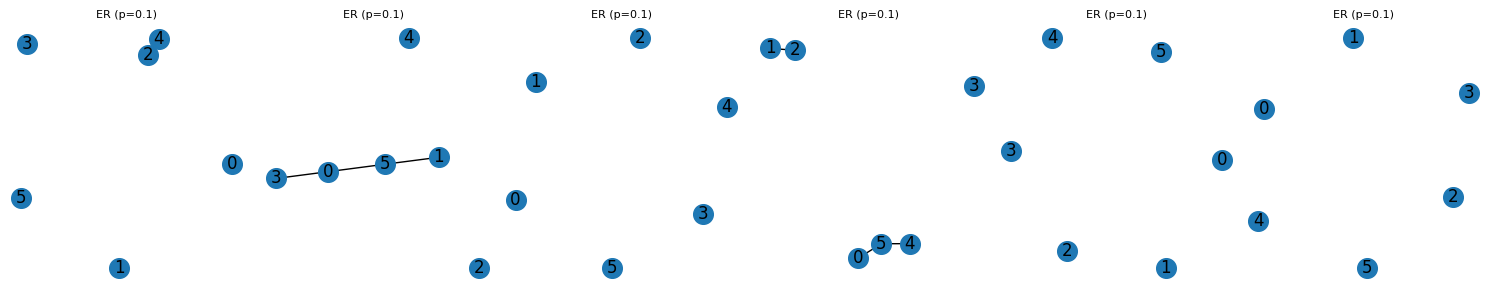

In [85]:
og_examples = []
og_pos = []
#Loading the dataset
dataset0 = ErdosRenyiDataset(num_nodes=6,
                                 num_samples=300,
                                 er_prob=0.10,
                                 seed=42)
#Storing vector of adjancency data in an array
X_p10 = []
for x_batch, y_batch in dataset0.get_train_dataset():
    X_p10.append(x_batch.numpy())
    
X_p10 = np.concatenate(X_p10, axis=0)

#Saving one for posterior comparation
adj = dataset0._vec_to_adj(X_p10[0])
G = nx.from_numpy_array(adj)
og_examples.append(G)
pos = nx.spring_layout(G, seed=int(dataset0.rng.integers(1000)))
og_pos.append(pos)

#Showing some examples
dataset0.plot_random_samples('train', num_samples=6)

In this figure, it can be seen very clear the situation when the value of the probability $p$ is under this critical value of $1/6$ in this case. The graphs are formed by many components, many subgraphs, rather than having a main subgraph component. In the following examples, the value of $p$ will be increased in order to see the phase change. 


Erdos-Renyi Dataset (k=6, p=0.25): 300 graphs
Train count: 240
Test count: 60


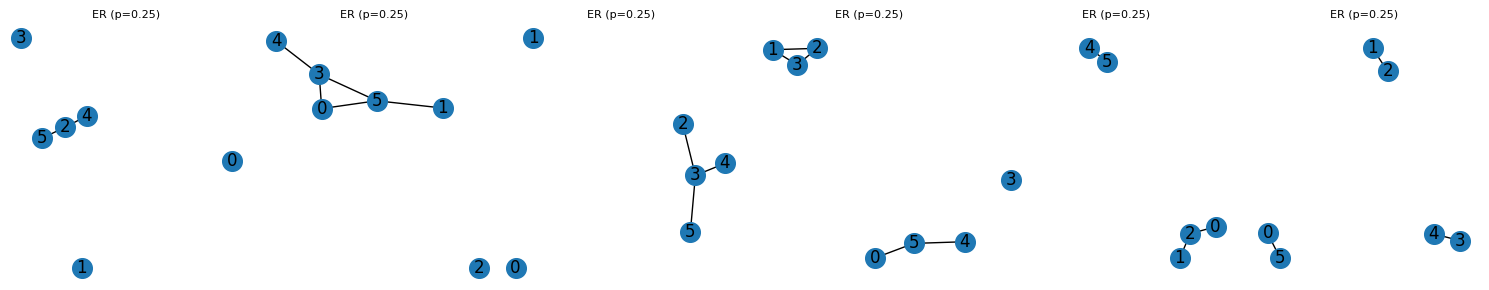

In [86]:
#Loading the dataset
dataset1 = ErdosRenyiDataset(num_nodes=6,
                                 num_samples=300,
                                 er_prob=0.25,
                                 seed=42)
#Storing vector of adjancency data in an array
X_p25 = []
for x_batch, y_batch in dataset1.get_train_dataset():
    X_p25.append(x_batch.numpy())
    
X_p25 = np.concatenate(X_p25, axis=0)

#Saving one for posterior comparation
adj = dataset1._vec_to_adj(X_p25[0])
G = nx.from_numpy_array(adj)
og_examples.append(G)
pos = nx.spring_layout(G, seed=int(dataset1.rng.integers(1000)))
og_pos.append(pos)

#Showing some examples
dataset1.plot_random_samples('train', num_samples=6)


Erdos-Renyi Dataset (k=6, p=0.45): 300 graphs
Train count: 240
Test count: 60


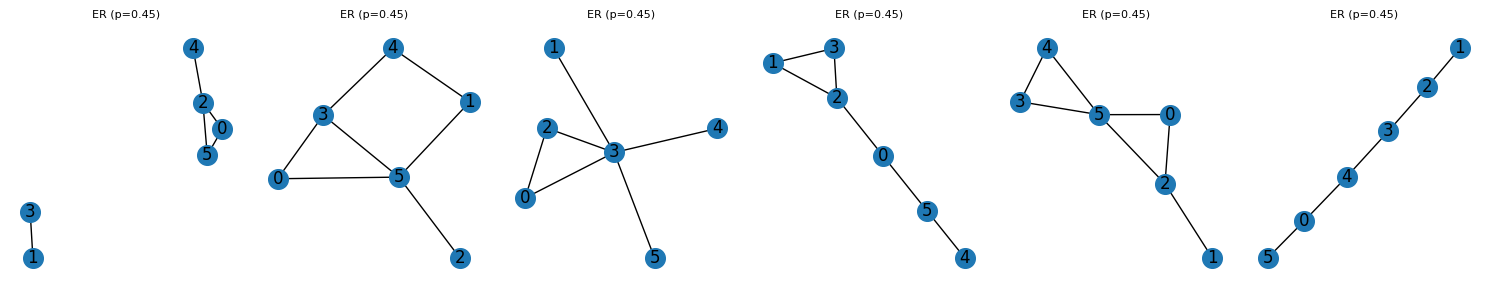

In [87]:
#Loading the dataset
dataset2 = ErdosRenyiDataset(num_nodes=6,
                                 num_samples=300,
                                 er_prob=0.45,
                                 seed=42)
#Storing vector of adjancency data in an array
X_p45 = []
for x_batch, y_batch in dataset2.get_train_dataset():
    X_p45.append(x_batch.numpy())

X_p45 = np.concatenate(X_p45, axis=0)

#Saving one for posterior comparation
adj = dataset2._vec_to_adj(X_p45[0])
G = nx.from_numpy_array(adj)
og_examples.append(G)
pos = nx.spring_layout(G, seed=int(dataset2.rng.integers(1000)))
og_pos.append(pos)

#Showing some examples
dataset2.plot_random_samples('train', num_samples=6)


Erdos-Renyi Dataset (k=6, p=0.65): 300 graphs
Train count: 240
Test count: 60


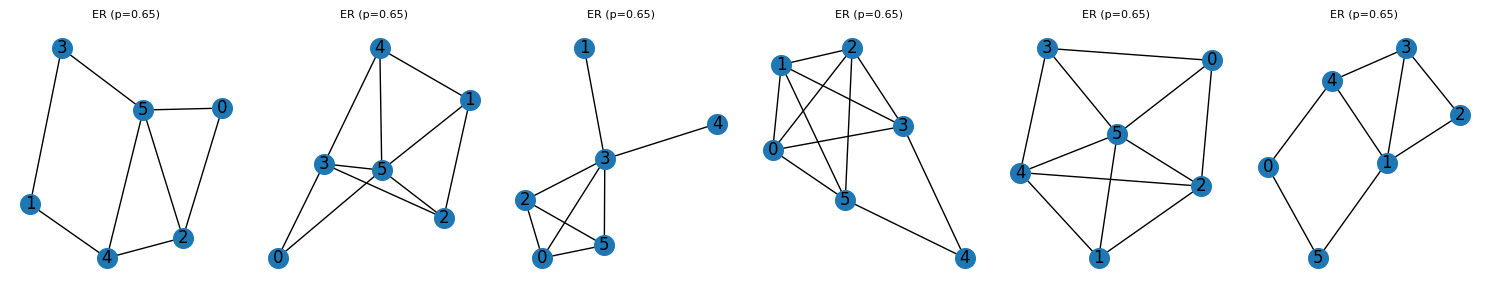

In [88]:
#Loading the dataset
dataset3 = ErdosRenyiDataset(num_nodes=6,
                                 num_samples=300,
                                 er_prob=0.65,
                                 seed=42)
#Storing vector of adjancency data in an array
X_p65 = []
for x_batch, y_batch in dataset3.get_train_dataset():
    X_p65.append(x_batch.numpy())

X_p65 = np.concatenate(X_p65, axis=0)

#Saving one for posterior comparation
adj = dataset3._vec_to_adj(X_p65[0])
G = nx.from_numpy_array(adj)
og_examples.append(G)
pos = nx.spring_layout(G, seed=int(dataset3.rng.integers(1000)))
og_pos.append(pos)

#Showing some examples
dataset3.plot_random_samples('train', num_samples=6)

## Parameterised IQP circuit 

Next step is to define the IQP circuit that will be used. For $6$-node graphs, $15$ qubits are needed. The circuit won't have a particular structure, but it will rather consists of all single-qubit rotations $R_X(\theta)$ and two-qubit rotations $R_{XX}(\theta)$ possible between the qubits. This is done through the function ```local_gates()```.

In [103]:
#Circuito IQP
nqubits = 15
gates = local_gates(n_qubits=nqubits,max_weight=2)
trained_ex = []

circ = iqp.IqpSimulator(nqubits,gates,device='lightning.qubit')

The only thing left to do is train the circuit with the different datasets generated previously. To evaluate the results, we will estimate in each case the  mean probability from the results of sampling the circuit, by simply estimating the number of non-zero entries in each result, i.e the number of edges from the corresponding graph, and calculating the mean.

6.928203


Training Progress: 100%|██████████| 500/500 [00:15<00:00, 32.96it/s, loss=-0.000104, elapsed time=0.03, total time=15.5]


Training has not converged after 500 steps


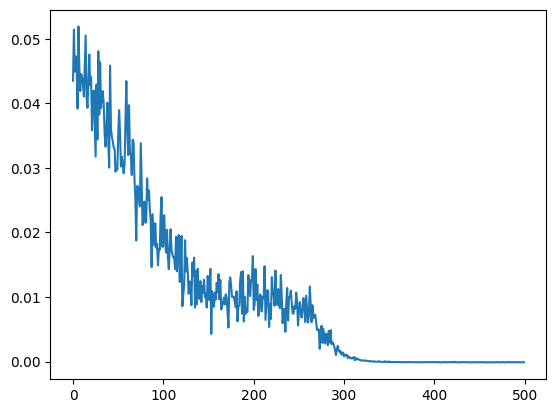

In [104]:
#Loss function
sigma = median_heuristic(X_p10)*4 #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)
#params_init = np.random.normal(0,1/np.sqrt(n_qubits), len(gates))
#params_init = jax.random.normal(key, (len(gates),)) * (1 / jnp.sqrt(nqubits))
params_init = initialize_from_data(gates, jnp.array(X_p10))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": jnp.array(X_p10), # samples from ground truth distribution
    "sigma": [sigma],
    "n_ops": 1000,
    "n_samples": 1000,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.003)
trainer.train(n_iters= 500,loss_kwargs=loss_kwarg)
trained_params10 = trainer.final_params
trained_ex.append(circ.sample(trained_params10))
plt.plot(trainer.losses)
plt.show() 

In [105]:
check = circ.sample(trained_params10, shots = 1000)
prob = 0
for v in check:
    prob += sum(v)/15

print('Mean probability from IQP sampled graphs:', prob/1000,' for p = 0.1')

Mean probability from IQP sampled graphs: 0.11206666666666758  for p = 0.1


9.797959


Training Progress: 100%|██████████| 500/500 [00:14<00:00, 34.48it/s, loss=-0.000100, elapsed time=0.03, total time=14.5]


Training has not converged after 500 steps


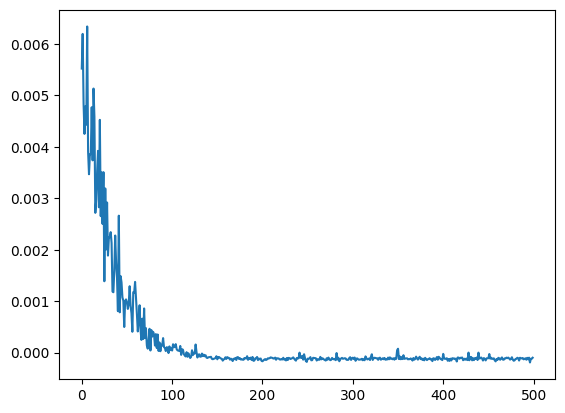

In [106]:
#Loss function
sigma = median_heuristic(X_p25)*4 #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)
#params_init = np.random.normal(0,1/np.sqrt(n_qubits), len(gates))
params_init = jax.random.normal(key, (len(gates),)) * (1 / jnp.sqrt(nqubits))
#params_init = initialize_from_data(gates, jnp.array(X))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": jnp.array(X_p25), # samples from ground truth distribution
    "sigma": [sigma],
    "n_ops": 1000,
    "n_samples": 1000,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.003)
trainer.train(n_iters= 500,loss_kwargs=loss_kwarg)
trained_params25 = trainer.final_params
trained_ex.append(circ.sample(trained_params25))
plt.plot(trainer.losses)
plt.show() 

In [107]:
check = circ.sample(trained_params25, shots = 1000)
prob = 0
for v in check:
    prob += sum(v)/15

print('Mean probability from IQP sampled graphs:', prob/1000,' for p = 0.25')

Mean probability from IQP sampled graphs: 0.2650000000000006  for p = 0.25


10.583005


Training Progress: 100%|██████████| 500/500 [00:15<00:00, 32.61it/s, loss=-0.000116, elapsed time=0.03, total time=15.3]


Training has not converged after 500 steps


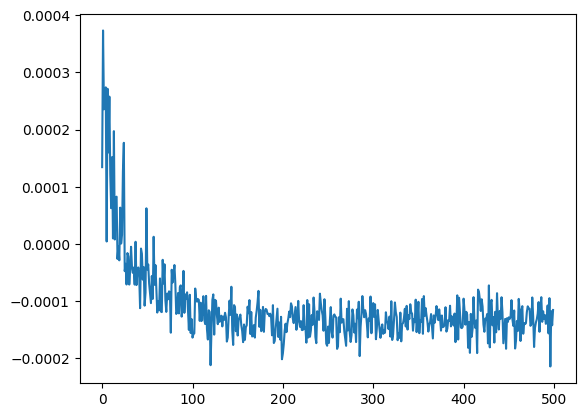

In [108]:
#Loss function
sigma = median_heuristic(X_p45)*4 #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)
#params_init = np.random.normal(0,1/np.sqrt(n_qubits), len(gates))
params_init = jax.random.normal(key, (len(gates),)) * (1 / jnp.sqrt(nqubits))
#params_init = initialize_from_data(gates, jnp.array(X))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": jnp.array(X_p45), # samples from ground truth distribution
    "sigma": [sigma],
    "n_ops": 1000,
    "n_samples": 1000,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.003)
trainer.train(n_iters= 500,loss_kwargs=loss_kwarg)
trained_params45 = trainer.final_params
trained_ex.append(circ.sample(trained_params45))
plt.plot(trainer.losses)
plt.show() 

In [109]:
check = circ.sample(trained_params45, shots = 1000)
prob = 0
for v in check:
    prob += sum(v)/15

print('Mean probability from IQP sampled graphs:', prob/1000,' for p = 0.45')

Mean probability from IQP sampled graphs: 0.46299999999999863  for p = 0.45


10.583005


Training Progress: 100%|██████████| 600/600 [00:21<00:00, 27.99it/s, loss=-0.000093, elapsed time=0.03, total time=21.4]


Training has not converged after 600 steps


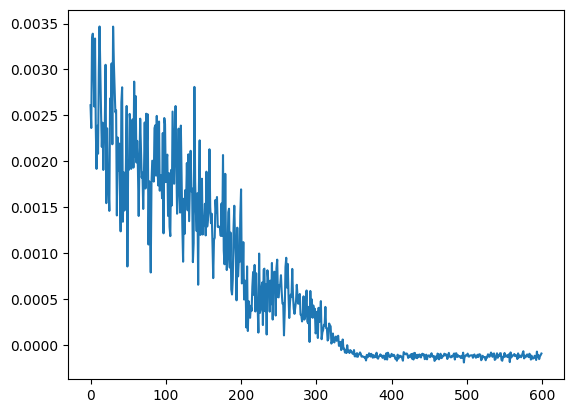

In [110]:
#Loss function
sigma = median_heuristic(X_p65)*4 #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)
#params_init = np.random.normal(0,1/np.sqrt(n_qubits), len(gates))
#params_init = jax.random.normal(key, (len(gates),)) * (1 / jnp.sqrt(nqubits))
params_init = initialize_from_data(gates, jnp.array(X_p65))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": jnp.array(X_p65), # samples from ground truth distribution
    "sigma": [sigma],
    "n_ops": 1000,
    "n_samples": 1000,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.003)
trainer.train(n_iters= 600,loss_kwargs=loss_kwarg)
trained_params65 = trainer.final_params
trained_ex.append(circ.sample(trained_params65))
plt.plot(trainer.losses)
plt.show() 

In [111]:
check = circ.sample(trained_params65, shots = 1000)
prob = 0
for v in check:
    prob += sum(v)/15

print('Mean probability from IQP sampled graphs:', prob/1000,' for p = 0.65')

Mean probability from IQP sampled graphs: 0.6487333333333355  for p = 0.65


Finally, let us put everything together into a figure for an easy comparison of results. In this following figure, we will show:

* Original graphs for each probability value.

* Untrained samples from IQP circuits with random parameters.

* Samples from IQP circuits after training for each probability value.

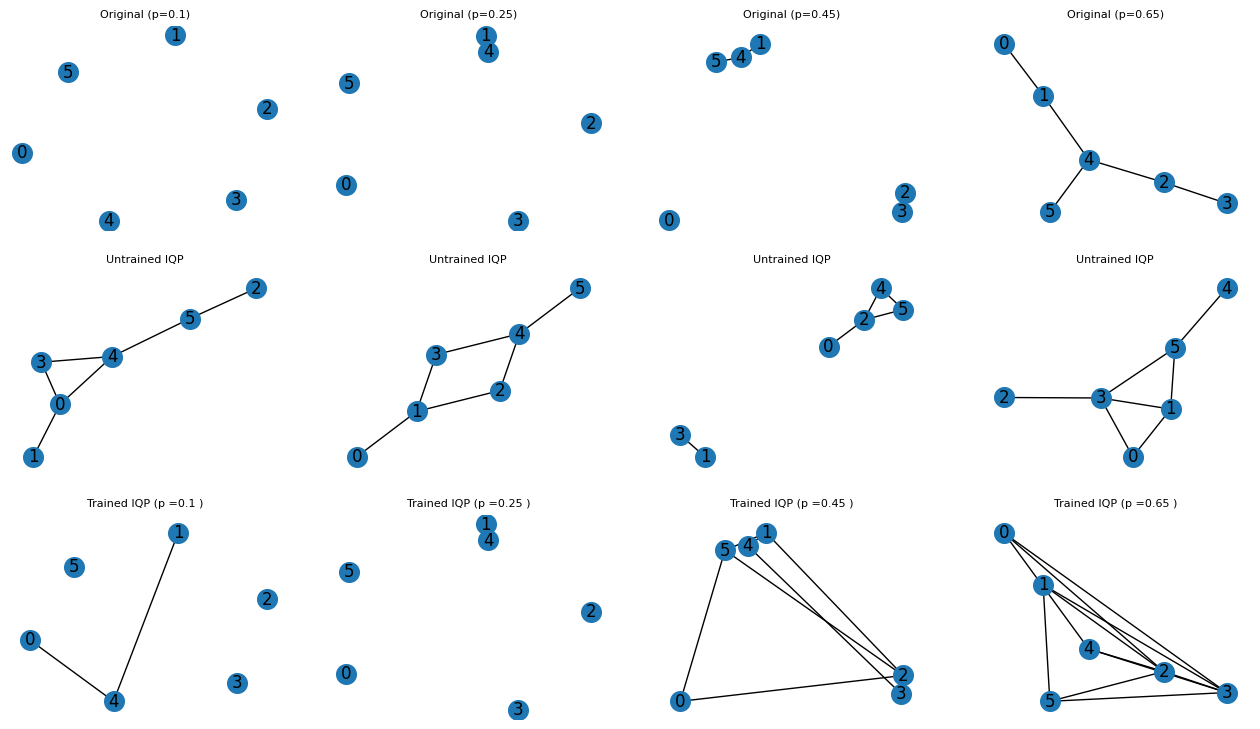

In [112]:
n = 4
probs = [0.1,0.25,0.45,0.65]
untrained = circ.sample(jax.random.normal(key, (len(gates),)) * (1 / jnp.sqrt(nqubits)), shots=4)
fig, axs = plt.subplots(3, n, figsize=(4 * n, 9))
for i in range(n):
    # 1. Plot original graph
    G = og_examples[i]
    pos = og_pos[i]
    ax_og = axs[0,i]
    nx.draw(G, pos, ax=ax_og, with_labels=True, node_size=200)
    ax_og.set_title(f"Original (p={probs[i]})", fontsize=8)
    

    #2. Untrained Results
    ax_un = axs[1, i] if n > 1 else axs[1]
    vec = untrained[i]
    adj = dataset0._vec_to_adj(vec)
    G = nx.from_numpy_array(adj)
    pos = nx.spring_layout(G, seed=40)
    nx.draw(G, pos, ax=ax_un, with_labels=True, node_size=200)
    ax_un.set_title('Untrained IQP', fontsize = 8)

    #3. Trained Results
    ax_t = axs[2, i] if n > 1 else axs[2]
    vec = trained_ex[i]
    adj = dataset0._vec_to_adj(vec)
    G = nx.from_numpy_array(adj)
    pos = og_pos[i]
    nx.draw(G, pos, ax=ax_t, with_labels=True, node_size=200)
    ax_t.set_title(f'Trained IQP (p ={probs[i]} )', fontsize = 8)
    